# 知识增益与上下文相关性
- 问题：随着知识增益的阈值提升，准确性增益是否也提升？
- **知识增益（Knowledge Gain, KG）**：不使用context的语义熵减去使用context的语义熵
- **知识增益阈值（Knowledge Gain Threshold, KGT）**：超过该阈值才使用context，否则不使用context

## 数据格式
`qwen-$dataset.pkl`

```
{
	"meta": {
		"model": "qwen",
		"dataset": "$dataset"
	},
	"data": [{
		"example": {
			"id": "id1",
			"question": "q1",
			"context": "c1",
			"answers": ["a1"]
		},
		"golden": {
			"greedy_response": "gready_text",
			"tbg_emb": Tensor(),
			"slt_emb": Tensor(),
			"sample_responses": ["response1","response2"],
			"cluster_ids": [0,1],
			"entropy": 1.5,
			"accuracy_qwen": 1.0,
			"accuracy_gpt": 1.0,
		},
		"irrelevant": {},
		"without": {},
	}]
}

```

In [1]:
%load_ext autoreload
%autoreload 2

import json
import warnings
import os
import pickle
from tqdm import tqdm
import torch
from collections import defaultdict, Counter
import argparse
from core.models.entailment import EntailmentDeberta
from core.data.data_utils import load_ds_from_json
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split
from core.computation.uncertainty_measure import cluster_assignment_entropy

warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 12})
rng = np.random.default_rng(42)


def load_pickle_file(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

def save_pickle_file(file_path, data):
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

def load_responses(generation_file_path):
    responses = []
    if os.path.exists(generation_file_path):
        res = load_pickle_file(generation_file_path)
        for r in res['responses']:
            it = {}
            it['text'] = r['text']
            it['slt_emb'] = r['hidden_states']['sec_last_token_embedding']
            it['tbg_emb'] = r['hidden_states']['last_tok_bef_gen_embedding']
            responses.append(it)
    return responses

def load_greedy_response(generation_file_path):
    responses = load_responses(generation_file_path)
    assert len(responses) <= 1, f"More than one response found in {generation_file_path}."
    return responses[0] if len(responses) == 1 else None

def load_sample_responses(generation_file_path):
    responses = []
    if os.path.exists(generation_file_path):
        res = load_pickle_file(generation_file_path)
        for r in res['responses']:
            responses.append(r['text'])
    return responses

def load_qwen_accuracy(eval_file_path):
    accuracy = []
    if os.path.exists(eval_file_path):
        res = load_pickle_file(eval_file_path)
        accuracy = res.get('qwen_scores', [])
    return accuracy[0] if len(accuracy) == 1 else None

def load_cluster_ids(clustered_file_path):
    cluster_ids = []
    if os.path.exists(clustered_file_path):
        res = load_pickle_file(clustered_file_path)
        cluster_ids = res.get('cluster_ids', [])
    return cluster_ids

# 计算语义熵
def compute_entropy(cluster_ids):
    if len(cluster_ids) == 0:
        return -1
    return cluster_assignment_entropy(cluster_ids)

# 检查数据是否完整
def check_item(item):
    for context_type in ["golden", "irrelevant", "without"]:
        if context_type not in item:
            return False
        context = item[context_type]
        if context.get("tbg_emb", None) is None:
            return False
        if context.get("slt_emb", None) is None:
            return False
        if context.get("greedy_response", None) is None:
            return False
        if context.get("sample_responses", None) is None:
            return False
        if context.get("cluster_ids", None) is None:
            return False
        if context.get("entropy", None) is None:
            return False
        if context.get("accuracy_qwen", None) is None:
            return False
        if len(context["sample_responses"]) != len(context["cluster_ids"]):
            return False
    
    return True

def load_data(dataset_name, model_name='qwen'):
    all_data = load_pickle_file(f"output/data/{model_name}-{dataset_name}.pkl")
    data = []
    for item in all_data["data"]:
        if check_item(item):
            data.append(item)
    return data

squad: 1998
squad - Knowledge Gain: -2.1729114780343375 ~ 3.401197381662155, Average: 0.8632354294712515


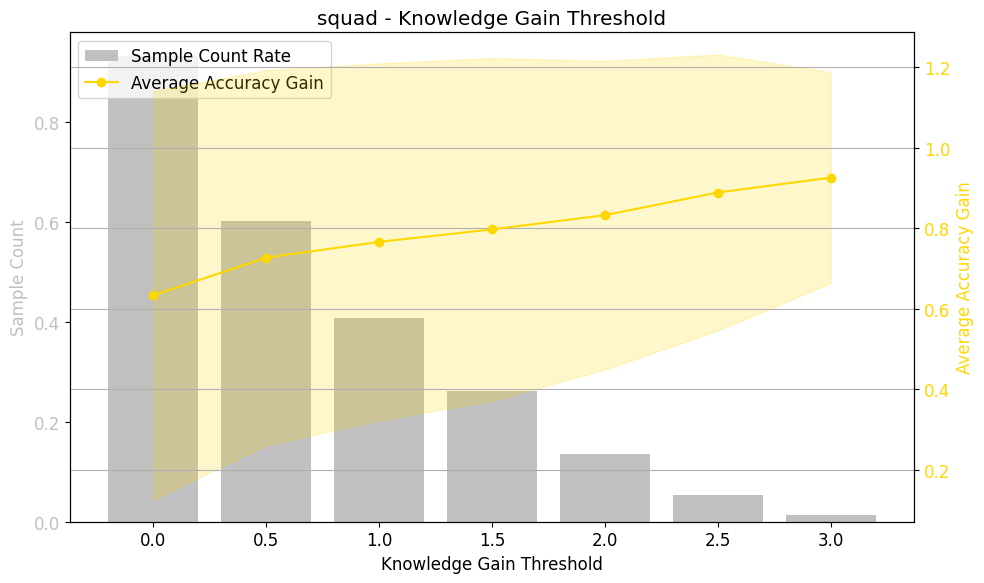

triviaqa: 1997
triviaqa - Knowledge Gain: -2.8292380324220474 ~ 3.198916528720685, Average: 0.16784919591901418


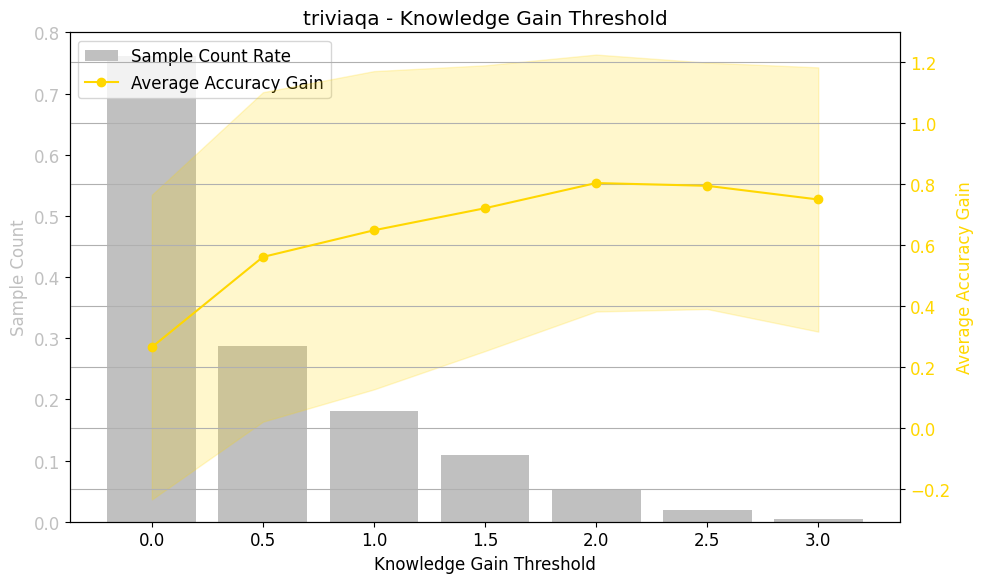

bioasq: 1997
bioasq - Knowledge Gain: -2.875447844459377 ~ 3.2451263407580146, Average: 0.022773359531657288


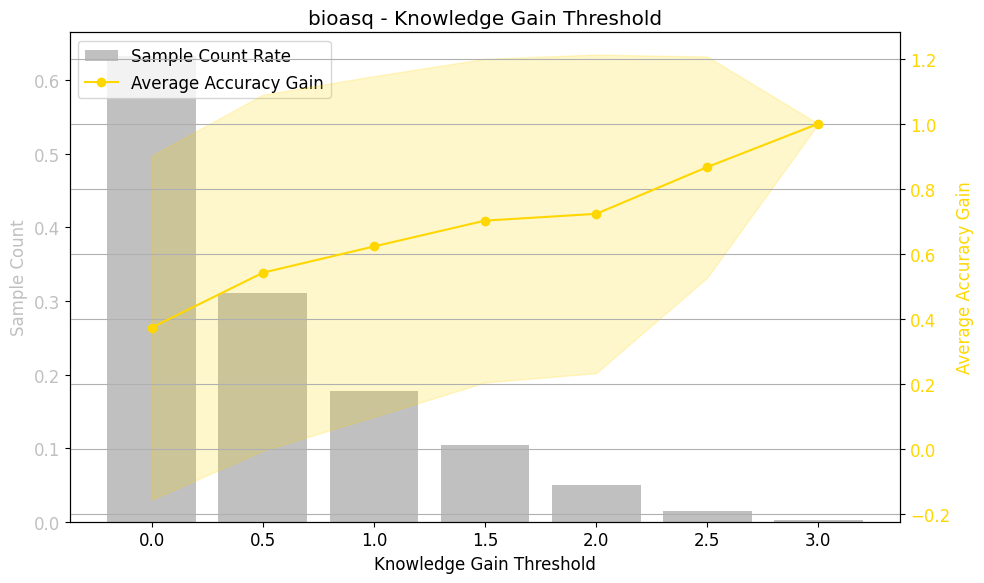

all: 5992
all - Knowledge Gain: -2.875447844459377 ~ 3.401197381662155, Average: 0.35137143379815616


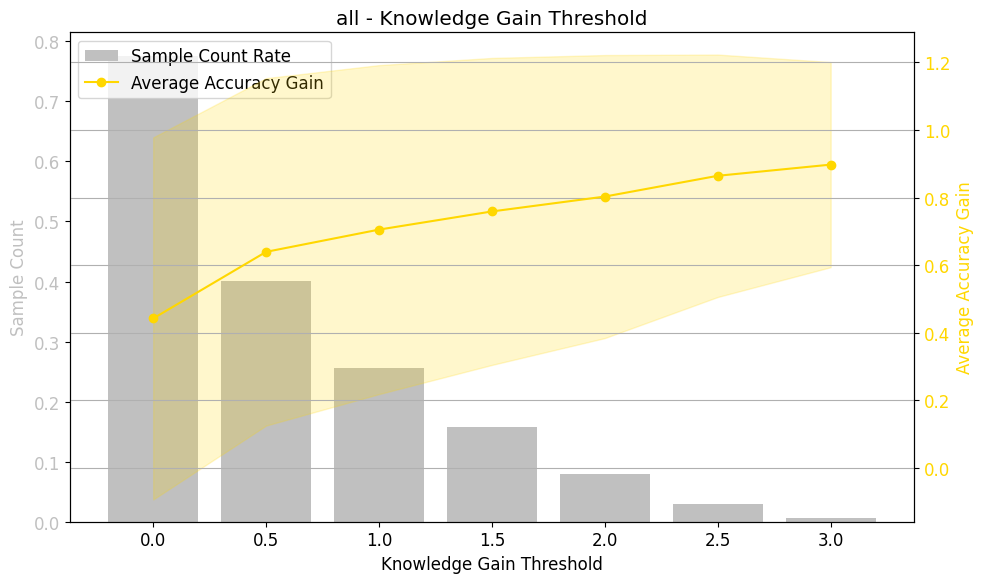

CPU times: user 5.21 s, sys: 5.5 s, total: 10.7 s
Wall time: 10.7 s


In [2]:
'''
- **知识增益（Knowledge Gain, KG）**：不使用context的语义熵减去使用context的语义熵
- **知识增益阈值（Knowledge Gain Threshold, KGT）**：超过该阈值才使用context，否则不使用context
- 绘制折线图
- 横轴是知识增益的阈值，从0开始，直到知识增益的最大值，分成10份（怎么控制步长为0.5？？）
- 纵轴是平均准确率
- 同时绘制柱状图，纵轴是样本数量占比
'''

import numpy as np
import matplotlib.pyplot as plt

def plot_knowledge_gain_threshold(data, dataset_name):
    # 计算知识增益
    kgs = []
    for item in data:
        kg = item["without"]["entropy"] - item["golden"]["entropy"]
        kgs.append(kg)
    kgs = np.array(kgs)
    print(f"{dataset_name} - Knowledge Gain: {kgs.min()} ~ {kgs.max()}, Average: {kgs.mean()}")

    # 设置阈值，从0开始，步长为0.5，直到知识增益的最大值
    step = 0.5
    thresholds = np.arange(0, kgs.max(), step)

    avg_accuracies = []
    sample_count_rates = []
    std_accuracies = []
    for threshold in thresholds:
        accuracies = []
        sample_count = 0
        for item in data:
            kg = item["without"]["entropy"] - item["golden"]["entropy"]
            if kg >= threshold:
                sample_count += 1
                # 计算准确率的增益，可以根据需求调整
                gain_accuracy = item["golden"]["accuracy_qwen"] - item["without"]["accuracy_qwen"]
                accuracies.append(gain_accuracy)
                
        # 计算平均准确率增益，避免除以零
        if sample_count > 0:
            avg_accuracies.append(np.mean(accuracies))
            std_accuracies.append(np.std(accuracies))
        
        sample_count_rates.append(sample_count / len(data))

    avg_accuracies = np.array(avg_accuracies)
    std_accuracies = np.array(std_accuracies)
    sample_count_rates = np.array(sample_count_rates)

    # 创建图形和主轴
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # 绘制柱状图（样本数量占比）在主轴上
    bar_width = step * 0.8  # 设置柱宽
    bars = ax1.bar(thresholds, sample_count_rates, width=bar_width, color='silver', label='Sample Count Rate')

    ax1.set_xlabel("Knowledge Gain Threshold")
    ax1.set_ylabel("Sample Count", color='silver')
    ax1.tick_params(axis='y', labelcolor='silver')

    # 创建第二个 y 轴共享同一个 x 轴
    ax2 = ax1.twinx()

    # 绘制折线图（平均准确率增益）在第二个 y 轴上
    line, = ax2.plot(thresholds, avg_accuracies, color='gold', marker='o', label='Average Accuracy Gain')
    ax2.set_ylabel("Average Accuracy Gain", color='gold')
    ax2.tick_params(axis='y', labelcolor='gold')

    # 添加标准差的阴影区域，并指定标签
    std_fill = ax2.fill_between(
        thresholds,
        avg_accuracies - std_accuracies,
        avg_accuracies + std_accuracies,
        color='gold',
        alpha=0.2,
        label='Std Dev'
    )

    # 添加图例
    lines_labels = [bars, line]
    labels = [l.get_label() for l in lines_labels]
    ax1.legend(lines_labels, labels, loc='upper left')

    plt.title(f"{dataset_name} - Knowledge Gain Threshold")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_all():
    all_data = []
    for dataset in ["squad", "triviaqa", "bioasq"]:
        data = load_data(dataset)
        print(f"{dataset}: {len(data)}")
        plot_knowledge_gain_threshold(data, dataset)
        all_data.extend(data)
    print(f"all: {len(all_data)}")
    plot_knowledge_gain_threshold(all_data, "all")

%time plot_all()

squad: 1998
squad - Knowledge Gain: -2.17 ~ 3.40, Average: 0.86


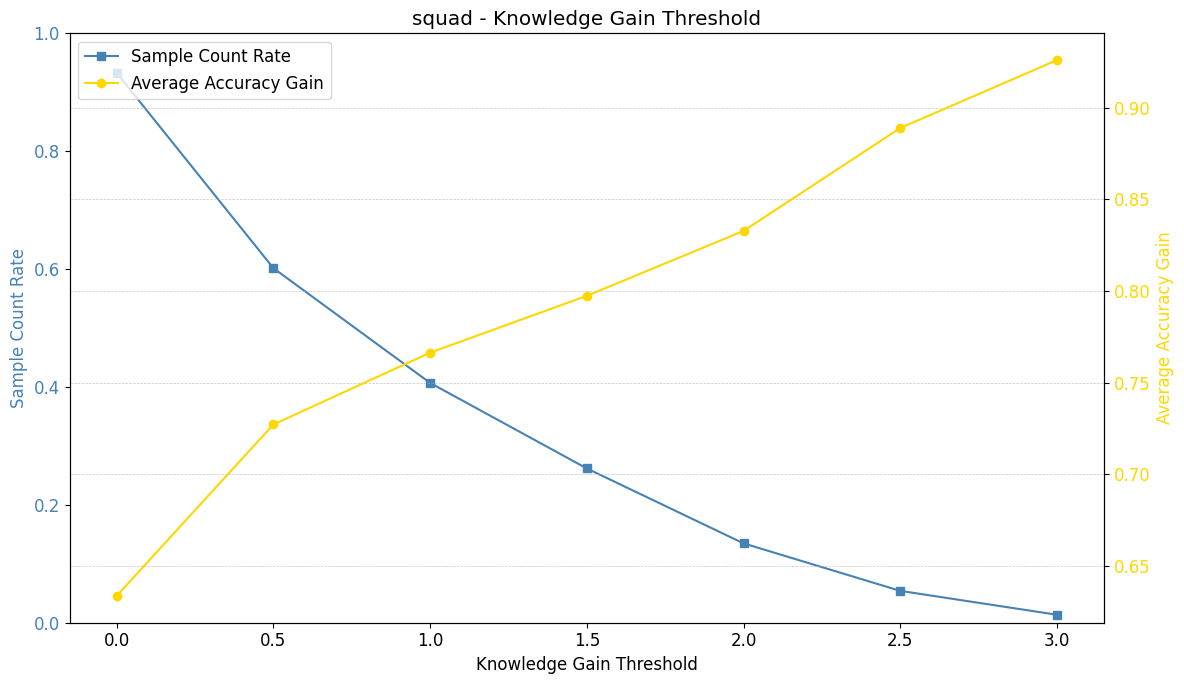

triviaqa: 1997
triviaqa - Knowledge Gain: -2.83 ~ 3.20, Average: 0.17


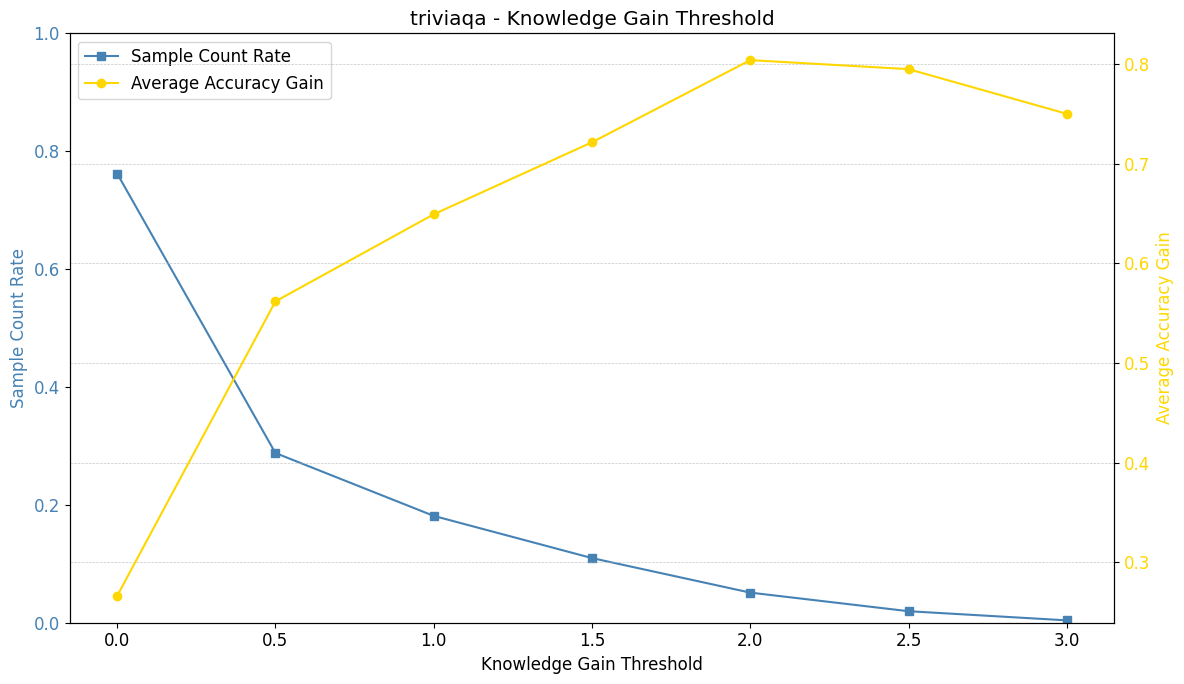

bioasq: 1997
bioasq - Knowledge Gain: -2.88 ~ 3.25, Average: 0.02


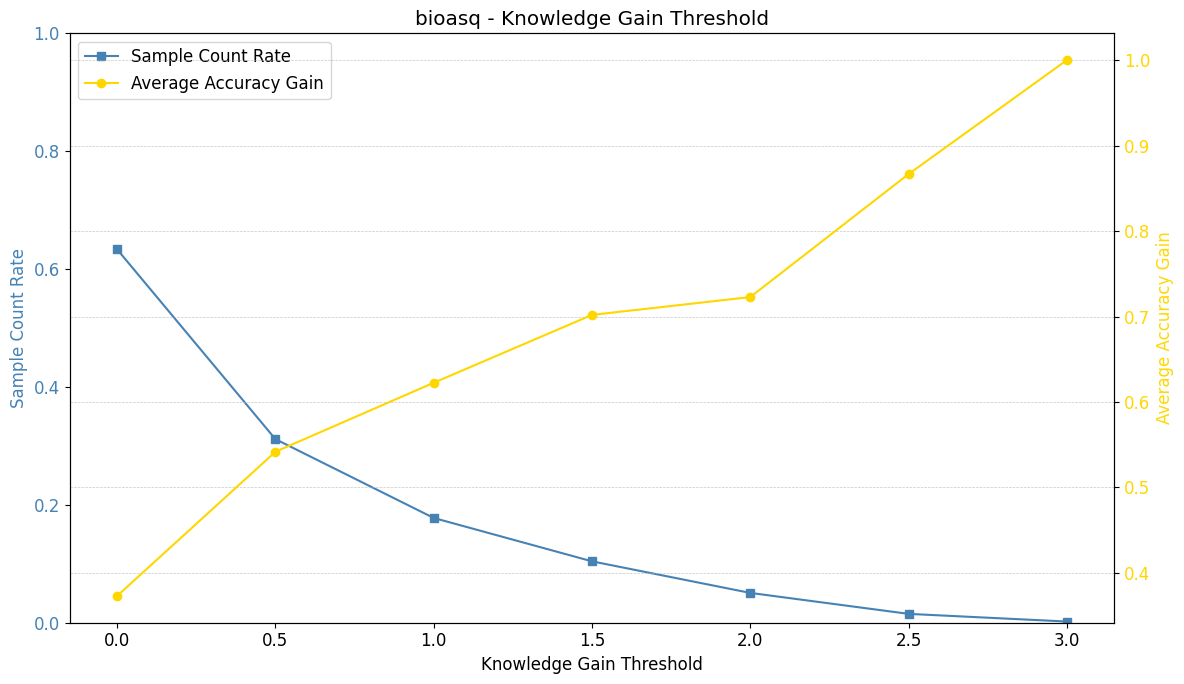

all: 5992
all - Knowledge Gain: -2.88 ~ 3.40, Average: 0.35


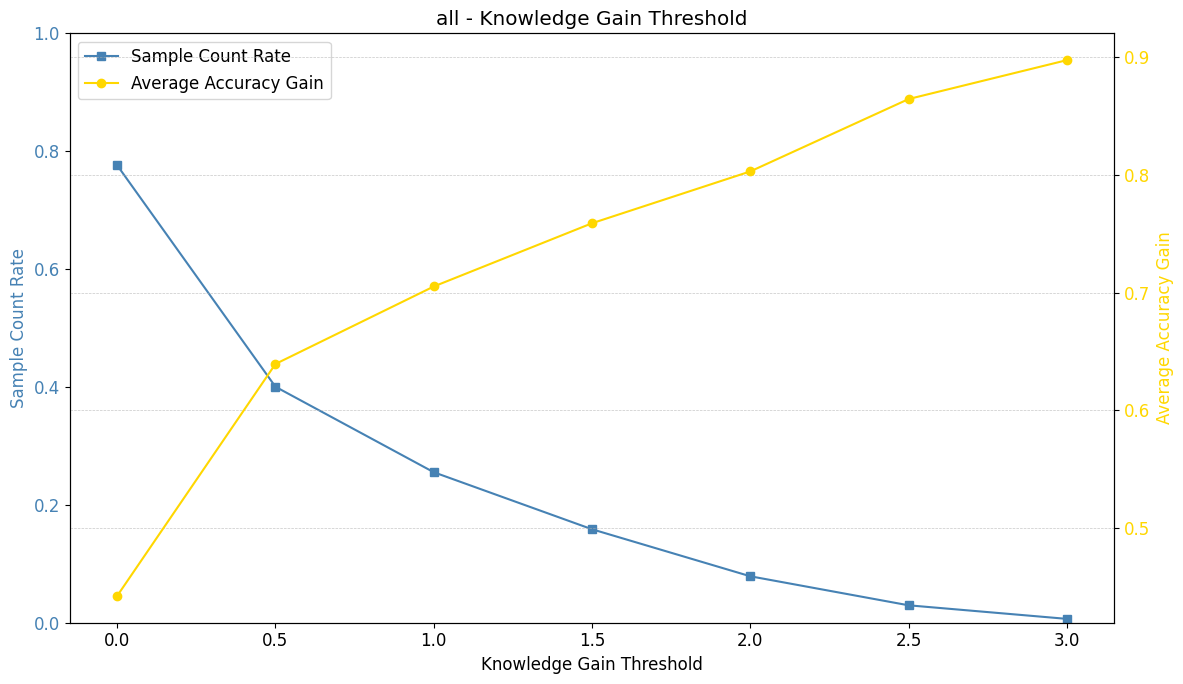

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_knowledge_gain_threshold(data, dataset_name):
    # 计算知识增益
    kgs = []
    for item in data:
        kg = item["without"]["entropy"] - item["golden"]["entropy"]
        kgs.append(kg)
    kgs = np.array(kgs)
    print(f"{dataset_name} - Knowledge Gain: {kgs.min():.2f} ~ {kgs.max():.2f}, Average: {kgs.mean():.2f}")

    # 设置阈值，从0开始，步长为0.5，直到知识增益的最大值
    step = 0.5
    thresholds = np.arange(0, kgs.max(), step)

    avg_accuracies = []
    std_accuracies = []
    sample_count_rates = []
    for threshold in thresholds:
        accuracies = []
        sample_count = 0
        for item in data:
            kg = item["without"]["entropy"] - item["golden"]["entropy"]
            if kg >= threshold:
                sample_count += 1
                # 计算准确率的增益
                gain_accuracy = item["golden"]["accuracy_qwen"] - item["without"]["accuracy_qwen"]
                accuracies.append(gain_accuracy)
        # 计算平均准确率增益和标准差，避免除以零
        if sample_count > 0:
            avg_accuracy = np.mean(accuracies)
            std_accuracy = np.std(accuracies)
        else:
            avg_accuracy = 0
            std_accuracy = 0
        avg_accuracies.append(avg_accuracy)
        std_accuracies.append(std_accuracy)
        sample_count_rates.append(sample_count / len(data))

    avg_accuracies = np.array(avg_accuracies)
    std_accuracies = np.array(std_accuracies)
    sample_count_rates = np.array(sample_count_rates)

    # 创建图形和主轴
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # 绘制折线图（样本数量占比）在主轴上
    line1, = ax1.plot(thresholds, sample_count_rates, color='steelblue', marker='s', label='Sample Count Rate')
    ax1.set_xlabel("Knowledge Gain Threshold")
    ax1.set_ylabel("Sample Count Rate", color='steelblue')
    ax1.tick_params(axis='y', labelcolor='steelblue')
    ax1.set_ylim(0, 1)  # 因为是占比

    # 创建第二个 y 轴共享同一个 x 轴
    ax2 = ax1.twinx()

    # 绘制折线图（平均准确率增益）在第二个 y 轴上
    line2, = ax2.plot(thresholds, avg_accuracies, color='gold', marker='o', label='Average Accuracy Gain')

    # # 添加标准差的阴影区域，并指定标签
    # std_fill = ax2.fill_between(
    #     thresholds,
    #     avg_accuracies - std_accuracies,
    #     avg_accuracies + std_accuracies,
    #     color='gold',
    #     alpha=0.2,
    #     label='Std Dev'
    # )

    ax2.set_ylabel("Average Accuracy Gain", color='gold')
    ax2.tick_params(axis='y', labelcolor='gold')

    # 添加图例
    # 获取两个轴的图例句柄和标签
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    # 合并图例
    handles = handles1 + [line2]
    labels = labels1 + ['Average Accuracy Gain', 'Std Dev']
    ax1.legend(handles, labels, loc='upper left')

    plt.title(f"{dataset_name} - Knowledge Gain Threshold")
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_all():
    all_data = []
    for dataset in ["squad", "triviaqa", "bioasq"]:
        data = load_data(dataset)
        print(f"{dataset}: {len(data)}")
        plot_knowledge_gain_threshold(data, dataset)
        all_data.extend(data)
    print(f"all: {len(all_data)}")
    plot_knowledge_gain_threshold(all_data, "all")

# 调用函数
# 注意：取消下面代码行的注释以实际运行
plot_all()

squad: 1998
squad - Knowledge Gain: -2.1729114780343375 ~ 3.401197381662155, Average: 0.8632354294712515
triviaqa: 1997
triviaqa - Knowledge Gain: -2.8292380324220474 ~ 3.198916528720685, Average: 0.16784919591901418
bioasq: 1997
bioasq - Knowledge Gain: -2.875447844459377 ~ 3.2451263407580146, Average: 0.022773359531657288
all: 5992
all - Knowledge Gain: -2.875447844459377 ~ 3.401197381662155, Average: 0.35137143379815616


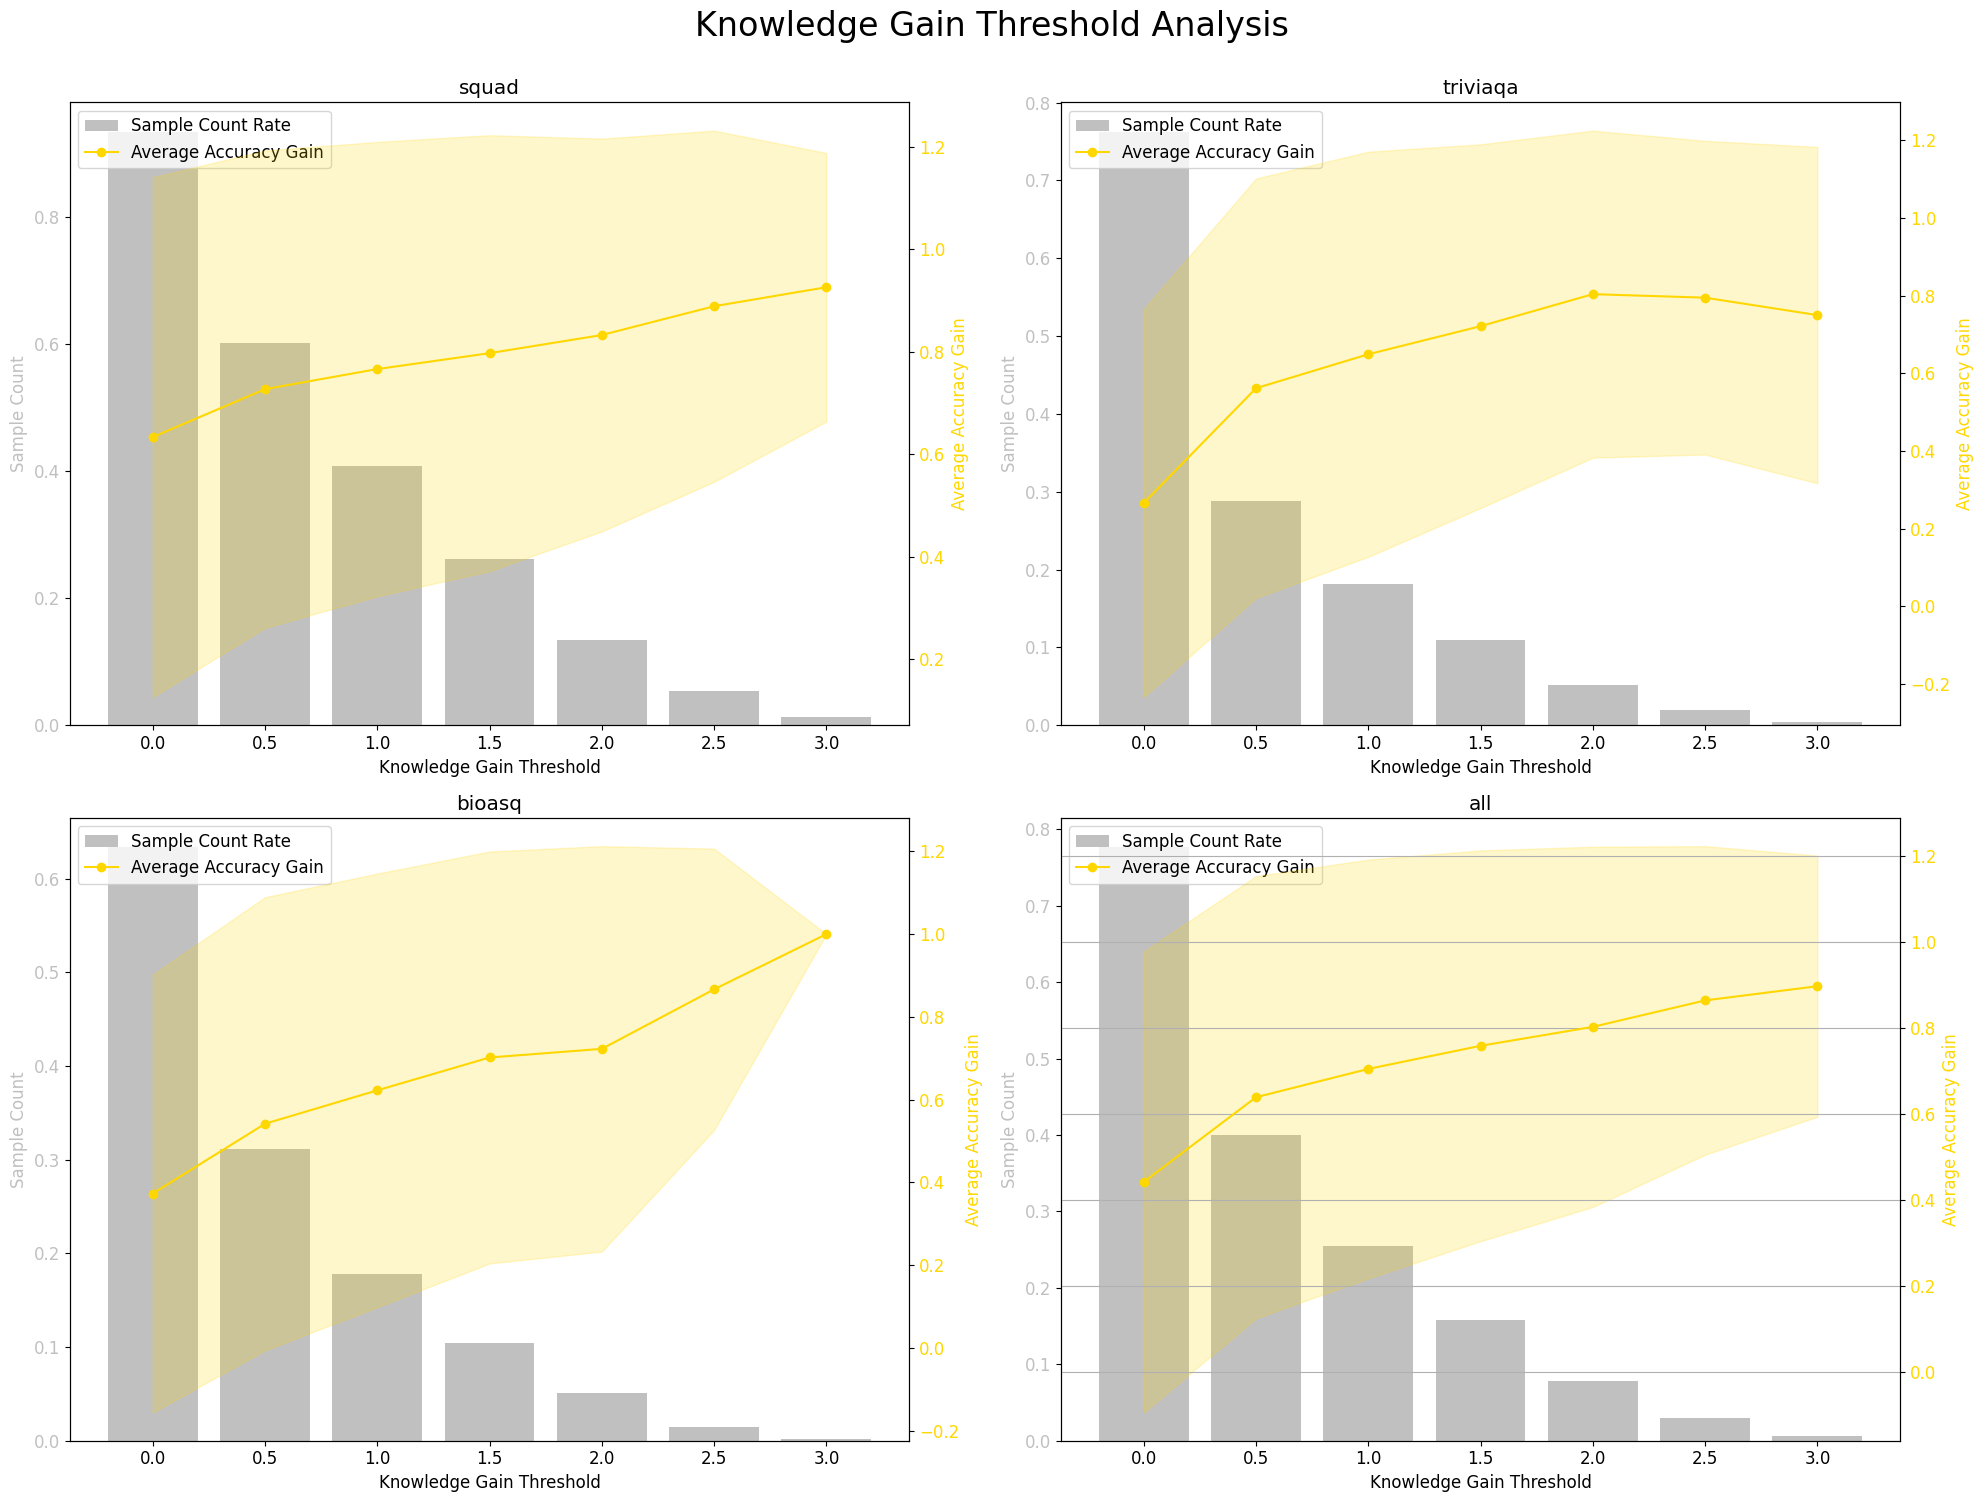

CPU times: user 5.74 s, sys: 1.94 s, total: 7.68 s
Wall time: 7.67 s


In [11]:
'''
- **知识增益（Knowledge Gain, KG）**：不使用context的语义熵减去使用context的语义熵
- **知识增益阈值（Knowledge Gain Threshold, KGT）**：超过该阈值才使用context，否则不使用context
- 绘制折线图
- 横轴是知识增益的阈值，从0开始，直到知识增益的最大值，分成10份（怎么控制步长为0.5？？）
- 纵轴是平均准确率
- 同时绘制柱状图，纵轴是样本数量占比
'''

import numpy as np
import matplotlib.pyplot as plt

def plot_knowledge_gain_threshold(ax1, ax2, data, dataset_name):
    """
    在给定的轴上绘制知识增益阈值图。

    参数：
    - ax1: 主轴，用于绘制样本数量占比的折线图。
    - ax2: 次轴，用于绘制平均准确率增益的折线图和标准差阴影区域。
    - data: 数据列表，每个元素是一个字典，包含 'without' 和 'golden' 两个键。
    - dataset_name: 数据集名称，用于图表标题。
    """

    # 计算知识增益
    kgs = []
    for item in data:
        kg = item["without"]["entropy"] - item["golden"]["entropy"]
        kgs.append(kg)
    kgs = np.array(kgs)
    print(f"{dataset_name} - Knowledge Gain: {kgs.min()} ~ {kgs.max()}, Average: {kgs.mean()}")

    # 设置阈值，从0开始，步长为0.5，直到知识增益的最大值
    step = 0.5
    thresholds = np.arange(0, kgs.max(), step)

    avg_accuracies = []
    sample_count_rates = []
    std_accuracies = []
    for threshold in thresholds:
        accuracies = []
        sample_count = 0
        for item in data:
            kg = item["without"]["entropy"] - item["golden"]["entropy"]
            if kg >= threshold:
                sample_count += 1
                # 计算准确率的增益，可以根据需求调整
                gain_accuracy = item["golden"]["accuracy_qwen"] - item["without"]["accuracy_qwen"]
                accuracies.append(gain_accuracy)
                
        # 计算平均准确率增益，避免除以零
        if sample_count > 0:
            avg_accuracies.append(np.mean(accuracies))
            std_accuracies.append(np.std(accuracies))
        
        sample_count_rates.append(sample_count / len(data))

    avg_accuracies = np.array(avg_accuracies)
    std_accuracies = np.array(std_accuracies)
    sample_count_rates = np.array(sample_count_rates)

    # 绘制柱状图（样本数量占比）在主轴上
    bar_width = step * 0.8  # 设置柱宽
    bars = ax1.bar(thresholds, sample_count_rates, width=bar_width, color='silver', label='Sample Count Rate')

    ax1.set_xlabel("Knowledge Gain Threshold")
    ax1.set_ylabel("Sample Count", color='silver')
    ax1.tick_params(axis='y', labelcolor='silver')

    # 创建第二个 y 轴共享同一个 x 轴
    ax2 = ax1.twinx()

    # 绘制折线图（平均准确率增益）在第二个 y 轴上
    line, = ax2.plot(thresholds, avg_accuracies, color='gold', marker='o', label='Average Accuracy Gain')
    ax2.set_ylabel("Average Accuracy Gain", color='gold')
    ax2.tick_params(axis='y', labelcolor='gold')

    # 添加标准差的阴影区域，并指定标签
    std_fill = ax2.fill_between(
        thresholds,
        avg_accuracies - std_accuracies,
        avg_accuracies + std_accuracies,
        color='gold',
        alpha=0.2,
        label='Std Dev'
    )

    # 添加图例
    lines_labels = [bars, line]
    labels = [l.get_label() for l in lines_labels]
    ax1.legend(lines_labels, labels, loc='upper left')

    # ax1.set_title(f"{dataset_name} - Knowledge Gain Threshold")
    ax1.set_title(dataset_name)

def plot_all():
    # 创建 2x2 的子图网格
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    axes = axes.flatten()  # 将二维数组展平成一维，便于迭代

    all_data = []
    datasets = ["squad", "triviaqa", "bioasq"]
    for idx, dataset in enumerate(datasets):
        data = load_data(dataset)
        print(f"{dataset}: {len(data)}")
        plot_knowledge_gain_threshold(axes[idx], axes[idx], data, dataset)
        all_data.extend(data)
    print(f"all: {len(all_data)}")
    plot_knowledge_gain_threshold(axes[3], axes[3], all_data, "all")

    # 设置整体标题
    fig.suptitle("Knowledge Gain Threshold Analysis", fontsize=24, y=1.0)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

%time plot_all()

squad: 1998
squad - Knowledge Gain: -2.17 ~ 3.40, Average: 0.86
triviaqa: 1997
triviaqa - Knowledge Gain: -2.83 ~ 3.20, Average: 0.17
bioasq: 1997
bioasq - Knowledge Gain: -2.88 ~ 3.25, Average: 0.02
all: 5992
all - Knowledge Gain: -2.88 ~ 3.40, Average: 0.35


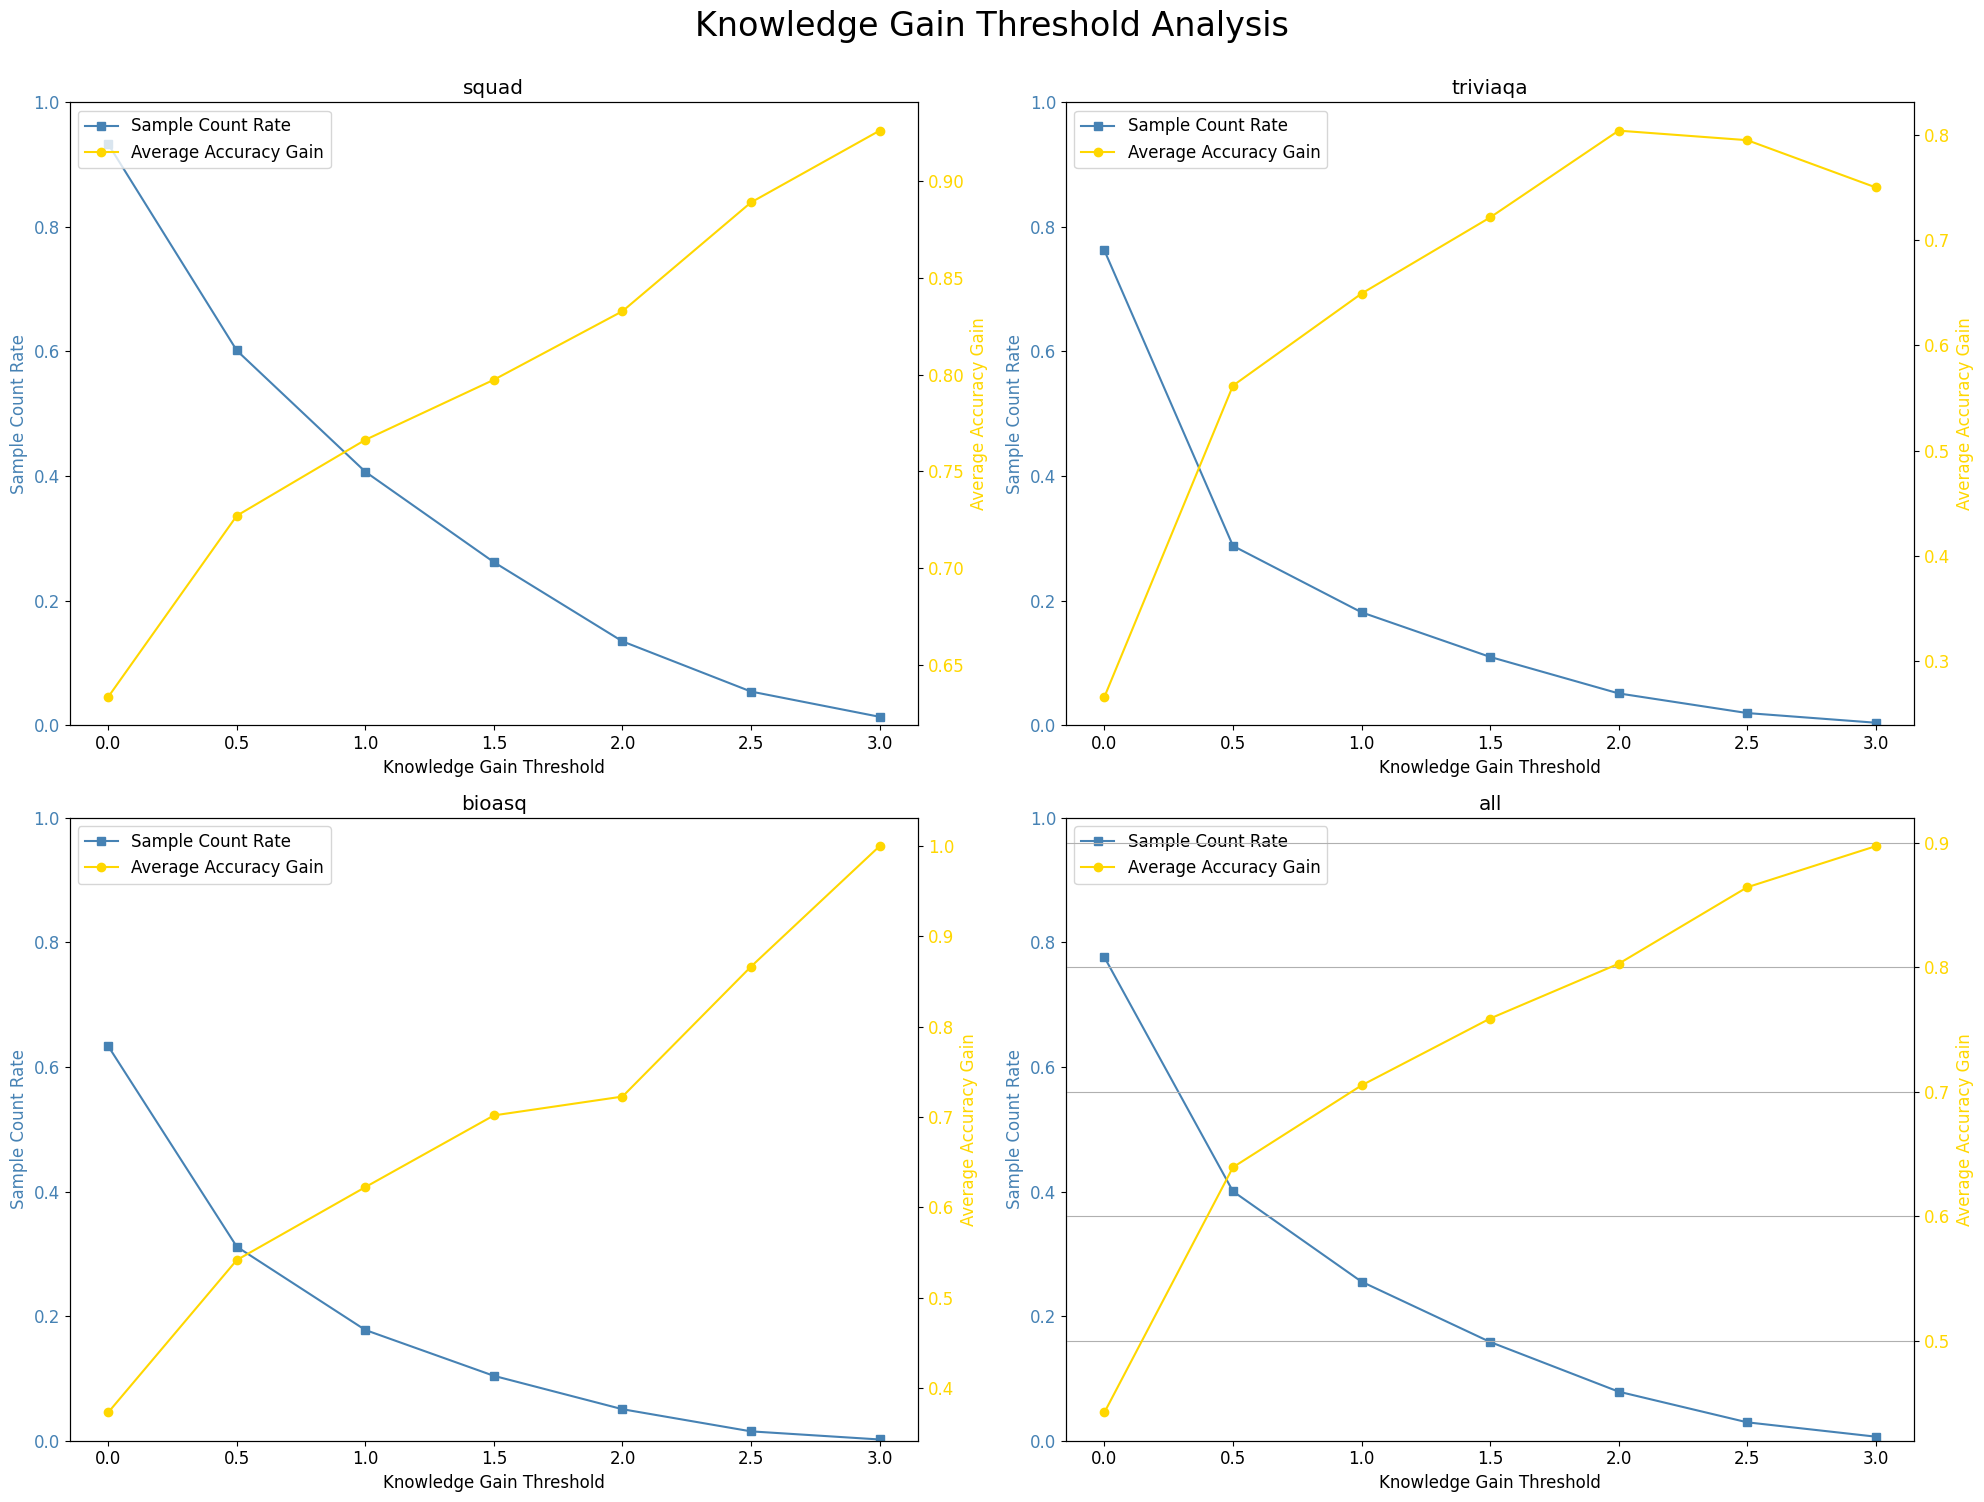

CPU times: user 5.57 s, sys: 1.99 s, total: 7.56 s
Wall time: 7.55 s


In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_knowledge_gain_threshold(ax1, ax2, data, dataset_name):
    # 计算知识增益
    kgs = []
    for item in data:
        kg = item["without"]["entropy"] - item["golden"]["entropy"]
        kgs.append(kg)
    kgs = np.array(kgs)
    print(f"{dataset_name} - Knowledge Gain: {kgs.min():.2f} ~ {kgs.max():.2f}, Average: {kgs.mean():.2f}")

    # 设置阈值，从0开始，步长为0.5，直到知识增益的最大值
    step = 0.5
    thresholds = np.arange(0, kgs.max(), step)

    avg_accuracies = []
    std_accuracies = []
    sample_count_rates = []
    for threshold in thresholds:
        accuracies = []
        sample_count = 0
        for item in data:
            kg = item["without"]["entropy"] - item["golden"]["entropy"]
            if kg >= threshold:
                sample_count += 1
                # 计算准确率的增益
                gain_accuracy = item["golden"]["accuracy_qwen"] - item["without"]["accuracy_qwen"]
                accuracies.append(gain_accuracy)
        # 计算平均准确率增益和标准差，避免除以零
        if sample_count > 0:
            avg_accuracy = np.mean(accuracies)
            std_accuracy = np.std(accuracies)
        else:
            avg_accuracy = 0
            std_accuracy = 0
        avg_accuracies.append(avg_accuracy)
        std_accuracies.append(std_accuracy)
        sample_count_rates.append(sample_count / len(data))

    avg_accuracies = np.array(avg_accuracies)
    std_accuracies = np.array(std_accuracies)
    sample_count_rates = np.array(sample_count_rates)

    # # 创建图形和主轴
    # fig, ax1 = plt.subplots(figsize=(12, 7))

    # 绘制折线图（样本数量占比）在主轴上
    line1, = ax1.plot(thresholds, sample_count_rates, color='steelblue', marker='s', label='Sample Count Rate')
    ax1.set_xlabel("Knowledge Gain Threshold")
    ax1.set_ylabel("Sample Count Rate", color='steelblue')
    ax1.tick_params(axis='y', labelcolor='steelblue')
    ax1.set_ylim(0, 1)  # 因为是占比

    # 创建第二个 y 轴共享同一个 x 轴
    ax2 = ax1.twinx()

    # 绘制折线图（平均准确率增益）在第二个 y 轴上
    line2, = ax2.plot(thresholds, avg_accuracies, color='gold', marker='o', label='Average Accuracy Gain')

    # # 添加标准差的阴影区域，并指定标签
    # std_fill = ax2.fill_between(
    #     thresholds,
    #     avg_accuracies - std_accuracies,
    #     avg_accuracies + std_accuracies,
    #     color='gold',
    #     alpha=0.2,
    #     label='Std Dev'
    # )

    ax2.set_ylabel("Average Accuracy Gain", color='gold')
    ax2.tick_params(axis='y', labelcolor='gold')

    # 添加图例
    # 获取两个轴的图例句柄和标签
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    # 合并图例
    handles = handles1 + [line2]
    labels = labels1 + ['Average Accuracy Gain', 'Std Dev']
    ax1.legend(handles, labels, loc='upper left')

    ax1.set_title(dataset_name)

def plot_all():
    # 创建 2x2 的子图网格
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    axes = axes.flatten()  # 将二维数组展平成一维，便于迭代

    all_data = []
    datasets = ["squad", "triviaqa", "bioasq"]
    for idx, dataset in enumerate(datasets):
        data = load_data(dataset)
        print(f"{dataset}: {len(data)}")
        plot_knowledge_gain_threshold(axes[idx], axes[idx], data, dataset)
        all_data.extend(data)
    print(f"all: {len(all_data)}")
    plot_knowledge_gain_threshold(axes[3], axes[3], all_data, "all")

    # 设置整体标题
    fig.suptitle("Knowledge Gain Threshold Analysis", fontsize=24, y=1.0)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

%time plot_all()